# Imports

In [1]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=300 # dots per inch
import scipy as sp
import itertools
rng = np.random.default_rng(seed=42)

## Extracting thermal conductivity from logfile


In [2]:
def extract_TC(file_path):
    """Extracts the thermal conductivity (TC) value from the logfile,
    assuming that the LAMMPS script has already been run.
    Also takes their thermal conductivities
    
    Inputs:
    file_path - path to the logfile we want to read
    
    Outputs:
    thermal_conductivity - thermal conductivity extracted from the logfile (if it is there)
    k_x - thermal conductivity along the x direction extracted from logfile
    k_y - thermal conductivity along the y direction extracted from logfile
    k_z - thermal conductivity along the z direction extracted from logfile
    """
    
    # Open file in Python to read all lines
    with open(file_path, 'r') as file:
        content = file.read()

    # Looks for lines of the form {average conductivity: X[W/mk] @ 70 K, Y /A\^3}
    k_pattern = re.compile(r'average conductivity:\s*([\d.]+)\s*\[W/mK\]', re.IGNORECASE)
    # Search logfile for that line
    k_lines = k_pattern.findall(content)
    
    # If the line exists, extract thermal conductivity. Inform user if otherwise
    if len(k_lines)>0:
        thermal_conductivity = float(k_lines[0])
    else:
        return 'Thermal conductivity not found for this file'
    
    # Look for lines of the form {diretional thermal conductivites: k_x = kx, k_y = ky, k_z = kz}
    ki_pattern = re.compile(
        r'Directional thermal conductivities:\s*'
        r'k_x\s*=\s*(?P<kx>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*,\s*'
        r'k_y\s*=\s*(?P<ky>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*,\s*'
        r'k_z\s*=\s*(?P<kz>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)',
        re.IGNORECASE)
    
    # If the line exists, extract directional conductivity. Inform user if otherwise
    ki_lines = ki_pattern.findall(content)
    if ki_lines:
        kx_str, ky_str, kz_str = ki_lines[0]
        kx = float(kx_str)
        ky = float(ky_str)
        kz = float(kz_str)
    else:
        return 'Directional thermal conductivites not found for this file'
    
    return thermal_conductivity, kx, ky, kz

## Updating the seed for the random velocities in LAMMPS


In [3]:
def update_seed(file_path, new_seed):
    """Updates the seed for the velocity initialisation command in the LAMMPS input script.
    The velocity in LAMMPS is randomly initialised using a given seed.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    new_seed - new seed to be used in velocity initialisation
    
    Outputs:
    Updated file, if amendments have been made"""
    
    # Looks for lines of the form {variable r equal X}
    pattern = re.compile(r'^\s*variable\s+r\s*equal\s*[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        for line in lines:
            # If the pattern exists, update the line with the new seed in place
            if pattern.match(line):
                line = f"variable r equal {new_seed}\n"
            
            # Write the line to the file
            file.write(line)

## Updating the masses of the atoms in LAMMPS input script


In [4]:
def update_masses(file_path, new_mass1, new_mass2):
    """Updates the mass1 and mass2 variables in the LAMMPS input script.
    This assumes of course that the LAMMPS script concerns two fundamental atoms.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    new_mass1 - new mass 1 (g/mol)
    new_mass2 - new mass 2 (g/mol)
    
    Outputs:
    Updated file, if any amendments have been made"""
    
    # Looks for lines of the form {mass    1 X} and {mass    2 Y}
    target_pattern_mass1 = re.compile(r'^\s*mass\s+1\s+[\d.]+\s*$')
    target_pattern_mass2 = re.compile(r'^\s*mass\s+2\s+[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        for line in lines:
            # --- Mass 1 ---
            # If the pattern exists, replace mass 1 with new_mass1
            if target_pattern_mass1.match(line):
                line = f"mass 1 {new_mass1}\n"
            # --- Mass 2 ---
            if target_pattern_mass2.match(line):
                line = f"mass 2 {new_mass2}\n"
                
            file.write(line)

## Updating dimensonality of LAMMPS input script

In [5]:
def update_dimensionality(file_path, new_dimension):
    """Updates the dimensionality written in the LAMMPS input script.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    
    Outputs:
    Updated file, if any amendments have been made"""
    
    # Look for lines of the form {dimension X}
    pattern = re.compile(r'^\s*dimension\s+(\d+)\b(?=\s*(?:#|$))')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        # Update any line which matches line pattern
        for line in lines:
            if pattern.match(line):
                line = f"dimension {new_dimension}\n"
            
            file.write(line)

## Bash function

In [6]:
def run_bash():
    """ I want to describe this better """
    !bash {'lammps.sh'}
    return

## Creating a LAMMPS-compatible datafile

In [7]:
def layered_datafile_creation(Ncells, Nlayers, spacings, type_ratio):
    """Creates a datafile of an arbitrary crystallographic material which is LAMMPS compatible.
    Uses the generate_FCC function to generate FCC lattice.
    See the markdown above where this function is defined for details on the datafile structure.
    Alternativiely, view the eim example in LAMMPS.
    
    Inputs:
    Ncells - number of cells as a two-dimensional NumPy vector [Nx, Nz]
    Nlayers - number of layers along y (integer)
    spacings - lattice constant / spacing between cells
    type_ratio - ratio between type 1 and 2 atoms
    
    Output:
    datafile.txt - datafile in LAMMPS format defining the structure"""

    # Find positions, types, IDs and group into data
    positions, atom_types, layer_types = generate_FCC(Ncells, Nlayers, spacings, type_ratio)
    num_atoms = len(atom_types)
    IDs = np.array(range(1, num_atoms+1))
    data = np.column_stack((IDs, atom_types, positions))

    # Will take the form [ID] [Type] [X1] [Y1] [Z1] column-repeated many times
    np.savetxt('datafile.txt', data, fmt = '%i %i %s %s %s',header = 
f'''# Title

{len(data)} atoms

2 atom types

{min(positions[:,0])} {max(positions[:,0]) + 0.5*spacings[0]} xlo xhi
{min(positions[:,1])} {max(positions[:,1]) + 0.5*spacings[1]} ylo yhi
{min(positions[:,2])} {max(positions[:,2]) + 0.5*spacings[2]} zlo zhi

Atoms
''', comments = '')
    
    return layer_types

In [8]:
def generate_FCC(Ncells, Nlayers, spacings, type2_ratio):
    """Creates a face-centered cubic (FCC) structure.
    This specific function assumes one type of atom only.
    
    Inputs:
    Ncells - number of cells as a two-dimensional NumPy vector [Nx, Nz]
    Nlayers - number of layers along y (integer)
    spacings - lattice constant / spacing between cells
    type2_ratio - ratio of type 2 layers: all layers
    
    Outputs:
    positions - two-dimensional NumPy array of positions [x,y,z] per atom
    type_atoms - one-dimensional NumPy array labelling atom types as integers
    layer_types - one-dimensional NumPy array labelling layer types as integers"""
    # Create storage arrays
    positions_even, positions_odd = [], []
    types_even, types_odd = [], []

    # Extract spacing and cells
    x_spacing, y_spacing, z_spacing = spacings
    Ncells_x, Ncells_z = Ncells

    # Determine Cartesian range of atoms
    x_range, z_range = range(2*Ncells_x), range(2*Ncells_z) 
    y_range = range(0, 2*Nlayers)
    
    # Randomly distribute layer types, according to the type 2 frequency
    type2_frequency = int(2*Nlayers*type2_ratio)
    layers_type1 = np.ones(2*Nlayers - type2_frequency)*1
    layers_type2 = np.ones(type2_frequency)*2
    layer_types = rng.permutation(np.concatenate([layers_type1, layers_type2]))
    layer_types = np.array(layer_types, dtype=np.int64)
    
    # Loop over the range of x,y,z
    for x,y,z in itertools.product(x_range, y_range, z_range):
        
        # Because we have indexed y=0,1,2,3,4... the type of the layer we are working with
        # can be extracted from layer_types
        atom_type = layer_types[y]
        
        # Check the first layer:
        if y%2 == 0:
            # Check if x+z is even
            if (x+z)%2 == 0:
                x, z = x*0.5*x_spacing, z*0.5*z_spacing
                y = (y//2)*y_spacing
                # Append positions and types
                positions_even.append([x,y,z])
                types_even.append(atom_type)
                
        # Check the second layer:
        elif y%2 == 1:
            # Check if x+z is odd
            if (x+z)%2 == 1:
                x, z = x*0.5*x_spacing, z*0.5*z_spacing
                y = (y//2 + 0.5)*y_spacing
                # Append positions and types
                positions_odd.append([x,y,z])
                types_odd.append(atom_type)
                                    
    # Convert lists to arrays for plotting & return
    positions_even = np.array(positions_even)
    positions_odd = np.array(positions_odd)
    positions = np.concatenate( (positions_even, positions_odd), axis=0 )
    types_even = np.array(types_even)
    types_odd = np.array(types_odd)
    atom_types = np.concatenate( (types_even, types_odd), axis=0 )
    
    return positions, atom_types, layer_types

In [9]:
# Set up arbitrary number of cells, layers spacings
Ncells = np.array([4,4])
Nlayers = 10
spacings = np.array([5.376, 5.376, 5.376])
# Update masses (not needed for what we're doing here)
update_masses("tc.txt", 39.948, 100.0)

# Extract positions
positions, atom_types, layer_types = generate_FCC(Ncells, Nlayers, spacings, 0.5)

# Count amount of occurences of type 1 and 2
atom_types = np.asarray(atom_types)
unique, counts = np.unique(atom_types, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(layer_types, return_counts=True)
print(dict(zip(unique, counts)))

{1: 320, 2: 320}
{1: 10, 2: 10}


A tree of what I want to do:

- Investigate the thermal conductivity of these ratios from 0.1 to 0.9 inclusive
    - For each ratio, randomly shuffle the layers ten times. This will hopefully sample quite a few of the possible combinations.
        - For each random shuffle, we will treat that as a system we want to investigate and minimise the thermal conductivity of. Therefore, we want to randomly initialise each random shuffle's initial velocity according to a random seed 10 times. This gives us a minimum TC for THAT specific random arrangement.
        
  
- I want to plot the thermal conductivity as a function of these ratios. So to this end, I will need an overall array, `k_averages`, which will contain the average TC for `ratio=0.1, 0.2, 0.3` etc.
    - Each entry in `k_averages` will be the average TC for that specific ratio. So to do that I will need another array called `k_ratio`, which contains the average TC's of each random shuffle of the corresponding ratio.
        - To find the average TC of each random shuffle I will need another array called `k_run`, which contains the TC's of all the individual initial seeds.

In [10]:
# Investigate 5x5x5
Ncells = np.array([5,5])
ratios = np.arange(0.1, 1, 0.1)
spacings = np.array([5.376,5.376,5.376])
update_masses("tc.txt", 39.948, 100.0)

# Setup array storage
k_ratio, k_errors = [], []
kx_ratio, kx_errors = [], []
ky_ratio, ky_errors = [], []
kz_ratio, kz_errors = [], []
all_layer_types = []
ratio_list = []

# Start off by considering every single type ratio in ratios:
for ratio in tqdm(ratios, desc="ratio", position=0):
    # We will do 10 runs for each ratio, to capture the full random shuffling of the types
    # So each run here represents a random distribution.
    for run in tqdm(range(10), desc="run", position=1, leave=False):
        k_run, kx_run, ky_run, kz_run = [], [], [], []
        layer_types = layered_datafile_creation(Ncells, 5, spacings, ratio)
        seeds = np.random.randint(1,100000,10)
        # Next for each run, we want to randomise the initial velocities
        # So for each random shuffling arrangement, we will randomise its initial velocity 10 times
        for seed in seeds:
            update_seed("tc.txt", seed)
            run_bash()
            # Extract TC and directional TC
            k_seed, kx_seed, ky_seed, kz_seed = extract_TC("log.lammps")
            # Store all seed TC's
            k_run.append(k_seed)
            kx_run.append(kx_seed)
            ky_run.append(ky_seed)
            kz_run.append(kz_seed)
        # Add the mean of that random distribution's TC to ratio array
        k_ratio.append(np.mean(k_run))
        kx_ratio.append(np.mean(kx_run))
        ky_ratio.append(np.mean(ky_run))
        kz_ratio.append(np.mean(kz_run))
        # Also find their errors
        k_errors.append(np.std(k_run, ddof=1) / np.sqrt(len(k_run)))
        kx_errors.append(np.std(kx_run, ddof=1) / np.sqrt(len(kx_run)))
        ky_errors.append(np.std(ky_run, ddof=1) / np.sqrt(len(ky_run)))
        kz_errors.append(np.std(kz_run, ddof=1) / np.sqrt(len(kz_run)))
        # Finally append layer type we are currently looking at to all_layer_types
        all_layer_types.append(layer_types)
        ratio_list.append(ratio)

ratio: 100%|████████████████████████████████████████████████████████████████████████| 9/9 [10:43:43<00:00, 4291.51s/it]


In [11]:
import pandas as pd

In [12]:
TC_dataframe = pd.DataFrame({
    "layer_types": all_layer_types,
    "ratio": ratio_list,
    "k":  k_ratio,
    "k error":  k_errors,
    "kx": kx_ratio,
    "kx error": kx_errors,
    "ky": ky_ratio,
    "ky error": ky_errors,
    "kz": kz_ratio,
    "kz error": kz_errors,
})

In [21]:
TC_dataframe

,layer_types,ratio,k,k error,kx,kx error,ky,ky error,kz,kz error
0,[1 2 1 1 1 1 1 1 1 1],0.1,0.251350,0.010175,0.254939,0.025972,0.210715,0.011312,0.288397,0.018703
1,[1 1 1 1 2 1 1 1 1 1],0.1,0.237749,0.009441,0.255688,0.019460,0.174313,0.011858,0.283247,0.016613
2,[1 1 1 1 1 1 1 2 1 1],0.1,0.221332,0.007022,0.246119,0.014098,0.180907,0.016429,0.236969,0.012217
3,[1 1 1 1 1 1 2 1 1 1],0.1,0.219705,0.007439,0.275384,0.014439,0.158566,0.011620,0.225163,0.022163
4,[1 1 1 2 1 1 1 1 1 1],0.1,0.223754,0.006580,0.252259,0.009702,0.148462,0.008982,0.270540,0.012459
...,...,...,...,...,...,...,...,...,...,...
85,[2 2 2 2 1 2 2 2 2 2],0.9,0.162505,0.005110,0.166227,0.011616,0.145631,0.007917,0.175658,0.011558
86,[2 1 2 2 2 2 2 2 2 2],0.9,0.157044,0.006044,0.184720,0.012821,0.131160,0.009567,0.155251,0.013857
87,[2 2 2 2 2 2 2 2 1 2],0.9,0.178384,0.004541,0.202163,0.011465,0.148808,0.007319,0.184181,0.009569
88,[2 2 1 2 2 2 2 2 2 2],0.9,0.155992,0.004871,0.159105,0.008738,0.137749,0.011878,0.171122,0.009975


In [14]:
TC_dataframe.to_csv("TC_dataframe.csv", index=False)

# Analysis of ratios
Since we expect kx, kz to be the same due to the symmetry of the structure along those two dimensions, the only direction which I will investigate is ky.

I checked if my error bars agree or not by considering the error of the difference between the two measurements. Because each measurement has an associated error, we can use error propagation to find the error of this difference.

If the difference between the two is smaller than the error of this difference then we say that these two measurements agree with eachother within their errors.

In [66]:
TC_dataframe = pd.read_csv("TC_dataframe.csv")

In [67]:
def pair_agreement(ratio_m):
    """Performs z-test on the difference between two measurements, taken from a table ratio_m.
    Inputs:
    ratio_m - the mth ratio in the dataframe"""
    # Extract TC and std dev from the ratio=0.1 dataframe
    k = ratio_m["ky"].values
    std_dev = ratio_m["ky error"].values

    # Storage for difference and error
    diff = np.zeros((len(k),len(k)))
    diff_error = np.zeros((len(k),len(k)))

    # Loop over all possible pairs (i,j) of TC, finding error
    for i in range(len(k)):
        for j in range(len(k)):
            diff[i,j] = np.abs(k[i] - k[j])
            diff_error[i,j] = np.sqrt(std_dev[i]**2 + std_dev[j]**2)

    # If the z statistic is less than 1, the errors agree with eachother
    agree = diff/diff_error <= 1

    # Find and print pairwise agreement
    for i in range(len(ratio_m)):
        agreeing_indices = np.where(agree[i])[0]
        print(f"Sample {i} agrees within 1 std dev with:", agreeing_indices)

In [69]:
def parse_layer_types(x):
    """Convert '[1 1 1 2 1 1 1 1 1 1]' -> [1,1,1,2,1,1,1,1,1,1]."""
    if isinstance(x, str):
        x = x.strip("[]")          # remove brackets
        parts = x.split()          # split on whitespace
        return [int(p) for p in parts]
    return x  # if it's already a list/array, just return it

def disorder_measure(seq):
    """Return disorder between 0 and 1 for a sequence of 1s and 2s."""
    seq = parse_layer_types(seq)
    if len(seq) < 2:
        return 0.0
    changes = sum(a != b for a, b in zip(seq[:-1], seq[1:]))
    return changes / (len(seq) - 1)

TC_dataframe["disorder"] = TC_dataframe["layer_types"].apply(disorder_measure)

## Ratio = 0.1

In [70]:
ratio_01 = TC_dataframe[TC_dataframe["ratio"] == 0.1]
# Display sorted dataframe
TC_dataframe[TC_dataframe["ratio"] == 0.1].sort_values(("ky"))

,layer_types,ratio,k,k error,kx,kx error,ky,ky error,kz,kz error,disorder
4,[1 1 1 2 1 1 1 1 1 1],0.1,0.223754,0.006580,0.252259,0.009702,0.148462,0.008982,0.270540,0.012459,0.222222
7,[1 1 1 1 2 1 1 1 1 1],0.1,0.232222,0.013378,0.270995,0.025646,0.148522,0.012336,0.277149,0.019158,0.222222
8,[1 1 1 1 1 1 1 2 1 1],0.1,0.225729,0.009644,0.229460,0.016063,0.152229,0.010474,0.295498,0.016464,0.222222
3,[1 1 1 1 1 1 2 1 1 1],0.1,0.219705,0.007439,0.275384,0.014439,0.158566,0.011620,0.225163,0.022163,0.222222
9,[1 1 1 1 1 1 1 2 1 1],0.1,0.212988,0.006004,0.251585,0.015666,0.158959,0.011653,0.228419,0.018291,0.222222
6,[1 1 1 1 1 1 1 1 2 1],0.1,0.214223,0.007675,0.238117,0.016462,0.164108,0.008924,0.240444,0.018906,0.222222
5,[1 1 1 1 1 1 2 1 1 1],0.1,0.223305,0.009404,0.257029,0.017124,0.172475,0.014715,0.240410,0.012728,0.222222
1,[1 1 1 1 2 1 1 1 1 1],0.1,0.237749,0.009441,0.255688,0.019460,0.174313,0.011858,0.283247,0.016613,0.222222
2,[1 1 1 1 1 1 1 2 1 1],0.1,0.221332,0.007022,0.246119,0.014098,0.180907,0.016429,0.236969,0.012217,0.222222
0,[1 2 1 1 1 1 1 1 1 1],0.1,0.251350,0.010175,0.254939,0.025972,0.210715,0.011312,0.288397,0.018703,0.222222


Interesting that index 4 has the smallest TC, why might this be? Notice that indices 8,9,2 are equivalent structures. So their errors should agree with eachother.

In [71]:
pair_agreement(ratio_01)

Sample 0 agrees within 1 std dev with: [0]
Sample 1 agrees within 1 std dev with: [1 2 3 5 6 9]
Sample 2 agrees within 1 std dev with: [1 2 5 6]
Sample 3 agrees within 1 std dev with: [1 3 4 5 6 7 8 9]
Sample 4 agrees within 1 std dev with: [3 4 7 8 9]
Sample 5 agrees within 1 std dev with: [1 2 3 5 6 9]
Sample 6 agrees within 1 std dev with: [1 2 3 5 6 8 9]
Sample 7 agrees within 1 std dev with: [3 4 7 8 9]
Sample 8 agrees within 1 std dev with: [3 4 6 7 8 9]
Sample 9 agrees within 1 std dev with: [1 3 4 5 6 7 8 9]


Even though 8,9 and 2 are equivalent, we observe an agreement between 8 and 9 but neither of them agree with 2.

## Ratio = 0.2

In [72]:
ratio_02 = TC_dataframe[TC_dataframe["ratio"] == 0.2]
# Display sorted dataframe
TC_dataframe[TC_dataframe["ratio"] == 0.2].sort_values(("ky"))

,layer_types,ratio,k,k error,kx,kx error,ky,ky error,kz,kz error,disorder
12,[1 1 2 1 1 1 1 2 1 1],0.2,0.180547,0.007268,0.238966,0.014976,0.091513,0.006147,0.211160,0.010756,0.444444
11,[1 1 1 2 1 1 1 1 1 2],0.2,0.179690,0.005850,0.227652,0.011949,0.101218,0.005952,0.210200,0.010018,0.333333
16,[2 1 1 1 1 2 1 1 1 1],0.2,0.179344,0.009934,0.219241,0.014245,0.106615,0.011743,0.212177,0.021324,0.333333
15,[1 2 1 1 2 1 1 1 1 1],0.2,0.179102,0.005298,0.208264,0.009723,0.108073,0.011763,0.220969,0.006267,0.444444
18,[1 1 2 1 1 2 1 1 1 1],0.2,0.175406,0.007758,0.217697,0.011584,0.108635,0.011761,0.199886,0.012173,0.444444
17,[1 1 1 1 1 2 1 2 1 1],0.2,0.199602,0.006856,0.234978,0.005697,0.117030,0.009012,0.246798,0.018988,0.444444
13,[2 1 1 1 1 1 1 1 2 1],0.2,0.199029,0.006868,0.251377,0.018390,0.119064,0.008544,0.226647,0.012698,0.333333
14,[1 1 1 1 2 1 2 1 1 1],0.2,0.185533,0.008322,0.193836,0.018973,0.132757,0.009480,0.230006,0.021584,0.444444
19,[2 1 1 1 1 1 1 1 1 2],0.2,0.224317,0.011747,0.252130,0.023919,0.153558,0.011353,0.267263,0.021967,0.222222
10,[1 2 2 1 1 1 1 1 1 1],0.2,0.215471,0.010399,0.252376,0.017707,0.164316,0.010729,0.229720,0.019155,0.222222


In [73]:
pair_agreement(ratio_02)

Sample 0 agrees within 1 std dev with: [0 9]
Sample 1 agrees within 1 std dev with: [1 5 6 8]
Sample 2 agrees within 1 std dev with: [2]
Sample 3 agrees within 1 std dev with: [3 5 6 7 8]
Sample 4 agrees within 1 std dev with: [4]
Sample 5 agrees within 1 std dev with: [1 3 5 6 7 8]
Sample 6 agrees within 1 std dev with: [1 3 5 6 7 8]
Sample 7 agrees within 1 std dev with: [3 5 6 7 8]
Sample 8 agrees within 1 std dev with: [1 3 5 6 7 8]
Sample 9 agrees within 1 std dev with: [0 9]


## Ratio = 0.3

In [74]:
ratio_03 = TC_dataframe[TC_dataframe["ratio"] == 0.3]
# Display sorted dataframe
TC_dataframe[TC_dataframe["ratio"] == 0.3].sort_values(("ky"))

,layer_types,ratio,k,k error,kx,kx error,ky,ky error,kz,kz error,disorder
22,[1 1 2 2 1 1 2 1 1 1],0.3,0.151758,0.006229,0.179405,0.014678,0.080536,0.008830,0.195333,0.006611,0.444444
28,[1 1 2 1 1 2 1 2 1 1],0.3,0.178479,0.006405,0.240001,0.012953,0.088388,0.006682,0.207048,0.014205,0.666667
24,[2 1 1 2 1 1 1 1 1 2],0.3,0.158615,0.005048,0.176758,0.007195,0.089124,0.008311,0.209964,0.016740,0.444444
25,[2 1 2 1 1 1 2 1 1 1],0.3,0.164637,0.004949,0.206974,0.011613,0.101252,0.007201,0.185685,0.009666,0.555556
26,[1 1 2 1 1 2 1 1 1 2],0.3,0.163296,0.004976,0.180129,0.014205,0.101285,0.009913,0.208474,0.009809,0.555556
21,[2 1 1 1 1 2 1 1 1 2],0.3,0.177404,0.005465,0.192591,0.009309,0.102855,0.005497,0.236766,0.021159,0.444444
27,[1 1 2 2 1 1 1 1 1 2],0.3,0.175901,0.008016,0.224365,0.016814,0.104723,0.007191,0.198615,0.009870,0.333333
20,[1 1 2 1 1 2 1 1 1 2],0.3,0.162946,0.007080,0.174251,0.007092,0.107035,0.006467,0.207552,0.017502,0.555556
29,[1 2 2 1 2 1 1 1 1 1],0.3,0.190745,0.006693,0.225171,0.012733,0.108950,0.010431,0.238113,0.011593,0.444444
23,[2 1 1 1 1 1 1 1 2 2],0.3,0.212227,0.009104,0.252419,0.012092,0.135678,0.005370,0.248585,0.018907,0.222222


In [75]:
pair_agreement(ratio_03)

Sample 0 agrees within 1 std dev with: [0 1 5 6 7 9]
Sample 1 agrees within 1 std dev with: [0 1 5 6 7 9]
Sample 2 agrees within 1 std dev with: [2 4 8]
Sample 3 agrees within 1 std dev with: [3]
Sample 4 agrees within 1 std dev with: [2 4 6 8]
Sample 5 agrees within 1 std dev with: [0 1 5 6 7 9]
Sample 6 agrees within 1 std dev with: [0 1 4 5 6 7 9]
Sample 7 agrees within 1 std dev with: [0 1 5 6 7 9]
Sample 8 agrees within 1 std dev with: [2 4 8]
Sample 9 agrees within 1 std dev with: [0 1 5 6 7 9]


## Ratio = 0.4

In [76]:
ratio_04 = TC_dataframe[TC_dataframe["ratio"] == 0.4]
# Display sorted dataframe
TC_dataframe[TC_dataframe["ratio"] == 0.4].sort_values(("ky"))

,layer_types,ratio,k,k error,kx,kx error,ky,ky error,kz,kz error,disorder
36,[1 1 1 2 2 1 1 2 1 2],0.4,0.136303,0.004042,0.167891,0.009712,0.072298,0.005092,0.168719,0.010786,0.555556
32,[1 1 2 1 1 2 2 1 1 2],0.4,0.146068,0.008561,0.180746,0.008621,0.084525,0.005264,0.172932,0.018641,0.555556
30,[2 1 1 1 2 1 2 1 1 2],0.4,0.155510,0.005585,0.180880,0.010537,0.085283,0.005467,0.200366,0.014127,0.666667
39,[2 1 1 1 1 2 2 1 1 2],0.4,0.158160,0.005171,0.199685,0.008473,0.087895,0.004194,0.186900,0.012338,0.444444
33,[1 1 1 2 1 1 2 2 2 1],0.4,0.161665,0.008265,0.201701,0.012443,0.089013,0.008086,0.194282,0.016267,0.444444
34,[2 1 2 2 1 1 2 1 1 1],0.4,0.167177,0.007722,0.225640,0.013906,0.095155,0.005883,0.180735,0.011815,0.555556
38,[1 2 2 2 1 1 1 1 2 1],0.4,0.154078,0.006321,0.194895,0.012056,0.097658,0.006638,0.169680,0.007601,0.444444
31,[1 2 1 2 2 1 1 2 1 1],0.4,0.157404,0.005522,0.183802,0.016202,0.101775,0.007984,0.186635,0.015988,0.666667
37,[1 1 1 1 2 1 2 2 1 2],0.4,0.163850,0.007079,0.192348,0.011213,0.109212,0.009754,0.189991,0.017961,0.555556
35,[2 1 2 2 2 1 1 1 1 1],0.4,0.170519,0.008715,0.189781,0.015766,0.116948,0.006433,0.204827,0.016815,0.333333


In [77]:
pair_agreement(ratio_04)

Sample 0 agrees within 1 std dev with: [0 2 3 9]
Sample 1 agrees within 1 std dev with: [1 4 7 8]
Sample 2 agrees within 1 std dev with: [0 2 3 9]
Sample 3 agrees within 1 std dev with: [0 2 3 4 8 9]
Sample 4 agrees within 1 std dev with: [1 3 4 8]
Sample 5 agrees within 1 std dev with: [5 7]
Sample 6 agrees within 1 std dev with: [6]
Sample 7 agrees within 1 std dev with: [1 5 7 8]
Sample 8 agrees within 1 std dev with: [1 3 4 7 8]
Sample 9 agrees within 1 std dev with: [0 2 3 9]


## Ratio = 0.5

In [78]:
ratio_05 = TC_dataframe[TC_dataframe["ratio"] == 0.5]
# Display sorted dataframe
TC_dataframe[TC_dataframe["ratio"] == 0.5].sort_values(("ky"))

,layer_types,ratio,k,k error,kx,kx error,ky,ky error,kz,kz error,disorder
47,[1 2 1 2 1 1 2 2 2 1],0.5,0.145769,0.006485,0.184143,0.011134,0.071862,0.006721,0.181302,0.016904,0.666667
40,[1 1 2 1 2 1 1 2 2 2],0.5,0.154178,0.007526,0.197931,0.009518,0.076150,0.006765,0.188453,0.011484,0.555556
41,[2 1 1 1 2 2 2 1 1 2],0.5,0.145532,0.007932,0.171097,0.009526,0.090394,0.006234,0.175106,0.011866,0.444444
46,[1 2 1 1 2 2 2 1 2 1],0.5,0.146684,0.008239,0.174265,0.011032,0.091588,0.007787,0.174198,0.020571,0.666667
44,[1 1 2 2 2 1 2 2 1 1],0.5,0.156258,0.008173,0.189713,0.013531,0.092999,0.008607,0.186062,0.011818,0.444444
49,[2 2 1 1 1 2 1 1 2 2],0.5,0.153573,0.004473,0.179873,0.014899,0.099945,0.006849,0.180901,0.012691,0.444444
48,[1 2 2 1 1 1 1 2 2 2],0.5,0.173152,0.008821,0.207432,0.011453,0.111421,0.007336,0.200603,0.015656,0.333333
45,[2 2 2 1 1 1 1 2 2 1],0.5,0.154614,0.007417,0.165190,0.020471,0.112483,0.005238,0.186169,0.011680,0.333333
42,[2 2 1 2 1 1 1 1 2 2],0.5,0.168405,0.007511,0.185279,0.014297,0.114705,0.006337,0.205233,0.011392,0.444444
43,[1 1 1 1 1 2 2 2 2 2],0.5,0.177231,0.006979,0.192368,0.014929,0.141506,0.010408,0.197818,0.008641,0.111111


In [90]:
print(disorder_measure(np.array([1,2,1,2,1,2,1,2,1,2])))

1.0


In [79]:
pair_agreement(ratio_05)

Sample 0 agrees within 1 std dev with: [0 7]
Sample 1 agrees within 1 std dev with: [1 4 6]
Sample 2 agrees within 1 std dev with: [2 5 8]
Sample 3 agrees within 1 std dev with: [3]
Sample 4 agrees within 1 std dev with: [1 4 6 9]
Sample 5 agrees within 1 std dev with: [2 5 8]
Sample 6 agrees within 1 std dev with: [1 4 6 9]
Sample 7 agrees within 1 std dev with: [0 7]
Sample 8 agrees within 1 std dev with: [2 5 8]
Sample 9 agrees within 1 std dev with: [4 6 9]


## Ratio = 0.6

In [80]:
ratio_06 = TC_dataframe[TC_dataframe["ratio"] == 0.6]
# Display sorted dataframe
TC_dataframe[TC_dataframe["ratio"] == 0.6].sort_values(("ky"))

,layer_types,ratio,k,k error,kx,kx error,ky,ky error,kz,kz error,disorder
59,[1 2 2 2 2 1 2 1 2 1],0.6,0.153210,0.006035,0.200771,0.013603,0.097945,0.006682,0.160914,0.010822,0.666667
56,[2 2 2 1 1 2 2 1 1 2],0.6,0.157872,0.006963,0.188171,0.016600,0.098865,0.009727,0.186581,0.011840,0.444444
54,[2 2 1 1 1 2 2 2 1 2],0.6,0.150037,0.004919,0.185672,0.013373,0.103198,0.004849,0.161240,0.010954,0.444444
50,[2 2 2 1 1 2 2 1 1 2],0.6,0.139228,0.005523,0.168602,0.010894,0.107967,0.004607,0.141114,0.011675,0.444444
53,[1 2 1 2 2 1 2 2 1 2],0.6,0.149402,0.006214,0.173756,0.012997,0.108544,0.009470,0.165905,0.007146,0.777778
51,[1 1 1 2 2 2 2 1 2 2],0.6,0.152440,0.007160,0.173634,0.012619,0.113810,0.011706,0.169874,0.013015,0.333333
55,[2 2 2 2 1 1 2 1 1 2],0.6,0.157053,0.008587,0.174856,0.012039,0.117605,0.007475,0.178698,0.018329,0.444444
57,[1 2 2 2 2 2 2 1 1 1],0.6,0.171531,0.004440,0.207894,0.012379,0.124704,0.004923,0.181996,0.004626,0.222222
58,[2 2 2 2 2 1 1 1 1 2],0.6,0.180549,0.006622,0.212816,0.012854,0.140307,0.011247,0.188524,0.012546,0.222222
52,[2 2 2 2 2 2 1 1 1 1],0.6,0.177312,0.003891,0.189110,0.013554,0.142725,0.011549,0.200102,0.015410,0.111111


In [81]:
pair_agreement(ratio_06)

Sample 0 agrees within 1 std dev with: [0 1 3 4 6]
Sample 1 agrees within 1 std dev with: [0 1 3 4 5 6 7]
Sample 2 agrees within 1 std dev with: [2 8]
Sample 3 agrees within 1 std dev with: [0 1 3 4 5 6 9]
Sample 4 agrees within 1 std dev with: [0 1 3 4 6 9]
Sample 5 agrees within 1 std dev with: [1 3 5 7]
Sample 6 agrees within 1 std dev with: [0 1 3 4 6 9]
Sample 7 agrees within 1 std dev with: [1 5 7]
Sample 8 agrees within 1 std dev with: [2 8]
Sample 9 agrees within 1 std dev with: [3 4 6 9]


## Ratio = 0.7

In [82]:
ratio_07 = TC_dataframe[np.isclose(TC_dataframe["ratio"], 0.7)]
# Display sorted dataframe
TC_dataframe[np.isclose(TC_dataframe["ratio"], 0.7)].sort_values("ky")

,layer_types,ratio,k,k error,kx,kx error,ky,ky error,kz,kz error,disorder
68,[2 2 2 2 1 2 1 2 2 1],0.7,0.151234,0.004656,0.170811,0.009665,0.100990,0.006262,0.181901,0.008852,0.555556
60,[2 2 2 1 2 2 1 1 2 2],0.7,0.140688,0.008535,0.169190,0.015551,0.106146,0.008440,0.146727,0.011148,0.444444
61,[2 1 2 2 2 2 1 1 2 2],0.7,0.147606,0.004050,0.179997,0.011642,0.106318,0.006777,0.156505,0.012232,0.444444
69,[2 2 2 1 2 2 2 1 1 2],0.7,0.153669,0.005747,0.163562,0.012336,0.109735,0.004302,0.187710,0.013162,0.444444
66,[2 2 2 2 2 1 2 2 1 1],0.7,0.153575,0.010117,0.174749,0.017803,0.111116,0.010368,0.174860,0.011292,0.333333
64,[2 2 2 1 2 1 2 1 2 2],0.7,0.164332,0.006123,0.198510,0.012447,0.113365,0.008347,0.181120,0.013406,0.666667
62,[2 2 1 2 1 2 2 2 1 2],0.7,0.159723,0.006668,0.196019,0.017761,0.113377,0.005011,0.169773,0.010867,0.666667
65,[2 2 2 1 2 2 1 1 2 2],0.7,0.154677,0.005807,0.178523,0.015748,0.114660,0.005171,0.170847,0.008338,0.444444
67,[2 2 2 2 1 1 2 2 1 2],0.7,0.156348,0.006306,0.173422,0.010181,0.118298,0.007522,0.177323,0.011148,0.444444
63,[2 2 2 2 2 1 2 1 1 2],0.7,0.165888,0.007790,0.197271,0.017096,0.126868,0.007401,0.173523,0.009784,0.444444


In [83]:
pair_agreement(ratio_07)

Sample 0 agrees within 1 std dev with: [0 1 2 4 5 6 8 9]
Sample 1 agrees within 1 std dev with: [0 1 2 4 5 6 8 9]
Sample 2 agrees within 1 std dev with: [0 1 2 4 5 6 7 9]
Sample 3 agrees within 1 std dev with: [3 7]
Sample 4 agrees within 1 std dev with: [0 1 2 4 5 6 7 9]
Sample 5 agrees within 1 std dev with: [0 1 2 4 5 6 7 9]
Sample 6 agrees within 1 std dev with: [0 1 2 4 5 6 7 8 9]
Sample 7 agrees within 1 std dev with: [2 3 4 5 6 7 9]
Sample 8 agrees within 1 std dev with: [0 1 6 8]
Sample 9 agrees within 1 std dev with: [0 1 2 4 5 6 7 9]


## Ratio = 0.8

In [84]:
ratio_08 = TC_dataframe[TC_dataframe["ratio"] == 0.8]
# Display sorted dataframe
TC_dataframe[TC_dataframe["ratio"] == 0.8].sort_values(("ky"))

,layer_types,ratio,k,k error,kx,kx error,ky,ky error,kz,kz error,disorder
79,[2 2 1 2 2 2 1 2 2 2],0.8,0.159002,0.007576,0.183051,0.012670,0.116347,0.009159,0.177610,0.011614,0.444444
74,[2 1 2 1 2 2 2 2 2 2],0.8,0.169570,0.005298,0.197647,0.009914,0.118687,0.008013,0.192374,0.013554,0.444444
72,[2 2 2 2 2 2 2 1 1 2],0.8,0.162984,0.007754,0.179434,0.014742,0.119934,0.009722,0.189585,0.017198,0.222222
76,[2 2 2 2 2 1 2 1 2 2],0.8,0.151226,0.005883,0.146703,0.013289,0.126528,0.007364,0.180448,0.010057,0.444444
73,[2 2 2 2 2 2 2 2 1 1],0.8,0.172161,0.007658,0.179800,0.014405,0.132679,0.010840,0.204003,0.014978,0.111111
70,[2 2 1 2 1 2 2 2 2 2],0.8,0.162608,0.005093,0.175815,0.011801,0.132983,0.010240,0.179026,0.009267,0.444444
78,[2 1 2 2 2 2 2 2 2 1],0.8,0.167671,0.004577,0.195975,0.009034,0.134286,0.007605,0.172751,0.014878,0.333333
77,[2 2 2 2 1 2 2 2 1 2],0.8,0.160632,0.007981,0.174573,0.015629,0.135261,0.009771,0.172060,0.011534,0.444444
71,[2 2 2 1 2 2 2 2 2 1],0.8,0.155127,0.006612,0.173361,0.009758,0.142632,0.008227,0.149387,0.012530,0.333333
75,[1 2 2 2 1 2 2 2 2 2],0.8,0.161633,0.007584,0.165667,0.011863,0.145841,0.010366,0.173392,0.014979,0.333333


In [85]:
pair_agreement(ratio_08)

Sample 0 agrees within 1 std dev with: [0 1 2 3 5 6 7 8]
Sample 1 agrees within 1 std dev with: [0 1 3 5 7 8]
Sample 2 agrees within 1 std dev with: [0 2 3 4 6 9]
Sample 3 agrees within 1 std dev with: [0 1 2 3 5 6 7 8]
Sample 4 agrees within 1 std dev with: [2 4 6 9]
Sample 5 agrees within 1 std dev with: [0 1 3 5 7 8]
Sample 6 agrees within 1 std dev with: [0 2 3 4 6 7 8 9]
Sample 7 agrees within 1 std dev with: [0 1 3 5 6 7 8]
Sample 8 agrees within 1 std dev with: [0 1 3 5 6 7 8]
Sample 9 agrees within 1 std dev with: [2 4 6 9]


## Ratio = 0.9

In [86]:
ratio_09 = TC_dataframe[TC_dataframe["ratio"] == 0.9]
# Display sorted dataframe
TC_dataframe[TC_dataframe["ratio"] == 0.9].sort_values(("ky"))

,layer_types,ratio,k,k error,kx,kx error,ky,ky error,kz,kz error,disorder
86,[2 1 2 2 2 2 2 2 2 2],0.9,0.157044,0.006044,0.184720,0.012821,0.131160,0.009567,0.155251,0.013857,0.222222
83,[2 2 2 2 2 2 1 2 2 2],0.9,0.158539,0.005289,0.162732,0.009344,0.134245,0.010980,0.178640,0.014329,0.222222
88,[2 2 1 2 2 2 2 2 2 2],0.9,0.155992,0.004871,0.159105,0.008738,0.137749,0.011878,0.171122,0.009975,0.222222
85,[2 2 2 2 1 2 2 2 2 2],0.9,0.162505,0.005110,0.166227,0.011616,0.145631,0.007917,0.175658,0.011558,0.222222
82,[1 2 2 2 2 2 2 2 2 2],0.9,0.169198,0.007932,0.181942,0.013263,0.146793,0.011467,0.178857,0.010813,0.111111
87,[2 2 2 2 2 2 2 2 1 2],0.9,0.178384,0.004541,0.202163,0.011465,0.148808,0.007319,0.184181,0.009569,0.222222
80,[2 2 2 2 2 2 2 2 2 1],0.9,0.168736,0.006078,0.185034,0.013377,0.149132,0.010728,0.172041,0.007708,0.111111
81,[2 2 2 2 2 1 2 2 2 2],0.9,0.166266,0.006654,0.185446,0.014967,0.152928,0.012575,0.160423,0.011300,0.222222
84,[2 2 2 2 2 2 2 2 2 1],0.9,0.184090,0.008142,0.182327,0.009089,0.160426,0.011113,0.209518,0.011946,0.111111
89,[2 2 2 2 2 2 2 2 1 2],0.9,0.171015,0.006783,0.172589,0.012933,0.167563,0.010857,0.172894,0.011944,0.222222


In [39]:
pair_agreement(ratio_09)

Sample 0 agrees within 1 std dev with: [0 1 2 3 4 5 7 8]
Sample 1 agrees within 1 std dev with: [0 1 2 4 5 7 8 9]
Sample 2 agrees within 1 std dev with: [0 1 2 3 4 5 7 8]
Sample 3 agrees within 1 std dev with: [0 2 3 5 6 8]
Sample 4 agrees within 1 std dev with: [0 1 2 4 7 9]
Sample 5 agrees within 1 std dev with: [0 1 2 3 5 7 8]
Sample 6 agrees within 1 std dev with: [3 6 8]
Sample 7 agrees within 1 std dev with: [0 1 2 4 5 7 8]
Sample 8 agrees within 1 std dev with: [0 1 2 3 5 6 7 8]
Sample 9 agrees within 1 std dev with: [1 4 9]


## Sorted by smallest $\kappa_y$

In [125]:
TC_dataframe.sort_values(("ky"))

,layer_types,ratio,k,k error,kx,kx error,ky,ky error,kz,kz error,disorder
47,[1 2 1 2 1 1 2 2 2 1],0.5,0.145769,0.006485,0.184143,0.011134,0.071862,0.006721,0.181302,0.016904,0.666667
36,[1 1 1 2 2 1 1 2 1 2],0.4,0.136303,0.004042,0.167891,0.009712,0.072298,0.005092,0.168719,0.010786,0.555556
40,[1 1 2 1 2 1 1 2 2 2],0.5,0.154178,0.007526,0.197931,0.009518,0.076150,0.006765,0.188453,0.011484,0.555556
22,[1 1 2 2 1 1 2 1 1 1],0.3,0.151758,0.006229,0.179405,0.014678,0.080536,0.008830,0.195333,0.006611,0.444444
32,[1 1 2 1 1 2 2 1 1 2],0.4,0.146068,0.008561,0.180746,0.008621,0.084525,0.005264,0.172932,0.018641,0.555556
...,...,...,...,...,...,...,...,...,...,...,...
89,[2 2 2 2 2 2 2 2 1 2],0.9,0.171015,0.006783,0.172589,0.012933,0.167563,0.010857,0.172894,0.011944,0.222222
5,[1 1 1 1 1 1 2 1 1 1],0.1,0.223305,0.009404,0.257029,0.017124,0.172475,0.014715,0.240410,0.012728,0.222222
1,[1 1 1 1 2 1 1 1 1 1],0.1,0.237749,0.009441,0.255688,0.019460,0.174313,0.011858,0.283247,0.016613,0.222222
2,[1 1 1 1 1 1 1 2 1 1],0.1,0.221332,0.007022,0.246119,0.014098,0.180907,0.016429,0.236969,0.012217,0.222222


### Errors 

In [143]:
mass1 = 39.948; mass2 = 100.0
ratios = np.arange(0.1,1,0.1)

avg_masses = (mass1*(1-ratios) + mass2*ratios)

In [152]:
# Group TC dataframe into ratios, this will make it easier to work with
grouped = TC_dataframe.groupby("ratio")

# Under the grouped dataframe, find mean and std dev amongst each ratio, treating each random structure as a sample under that ratio.
# This means that the standard deviation we find for this sample is taken to be the std dev of the population for that ratio (the MLE)
k_stats = grouped.agg(k_mean  = ("k",  "mean"), k_std   = ("k",  "std"),
    kx_mean = ("kx", "mean"), kx_std  = ("kx", "std"),
    ky_mean = ("ky", "mean"), ky_std  = ("ky", "std"),
    kz_mean = ("kz", "mean"), kz_std  = ("kz", "std"),)

# We use the formula for the std dev of the sample mean, treating the random structure as a sample under a ratio
# VarX = sigma^2/N where N is the size of sample and sigma^2 is the variance of the population
k_stats["k_err"]  = k_stats["k_std"]  / np.sqrt( grouped.size() )
k_stats["kx_err"] = k_stats["kx_std"] / np.sqrt( grouped.size() )
k_stats["ky_err"] = k_stats["ky_std"] / np.sqrt( grouped.size() )
k_stats["kz_err"] = k_stats["kz_std"] / np.sqrt( grouped.size() )


k_stats = k_stats.reset_index().sort_values("ratio")

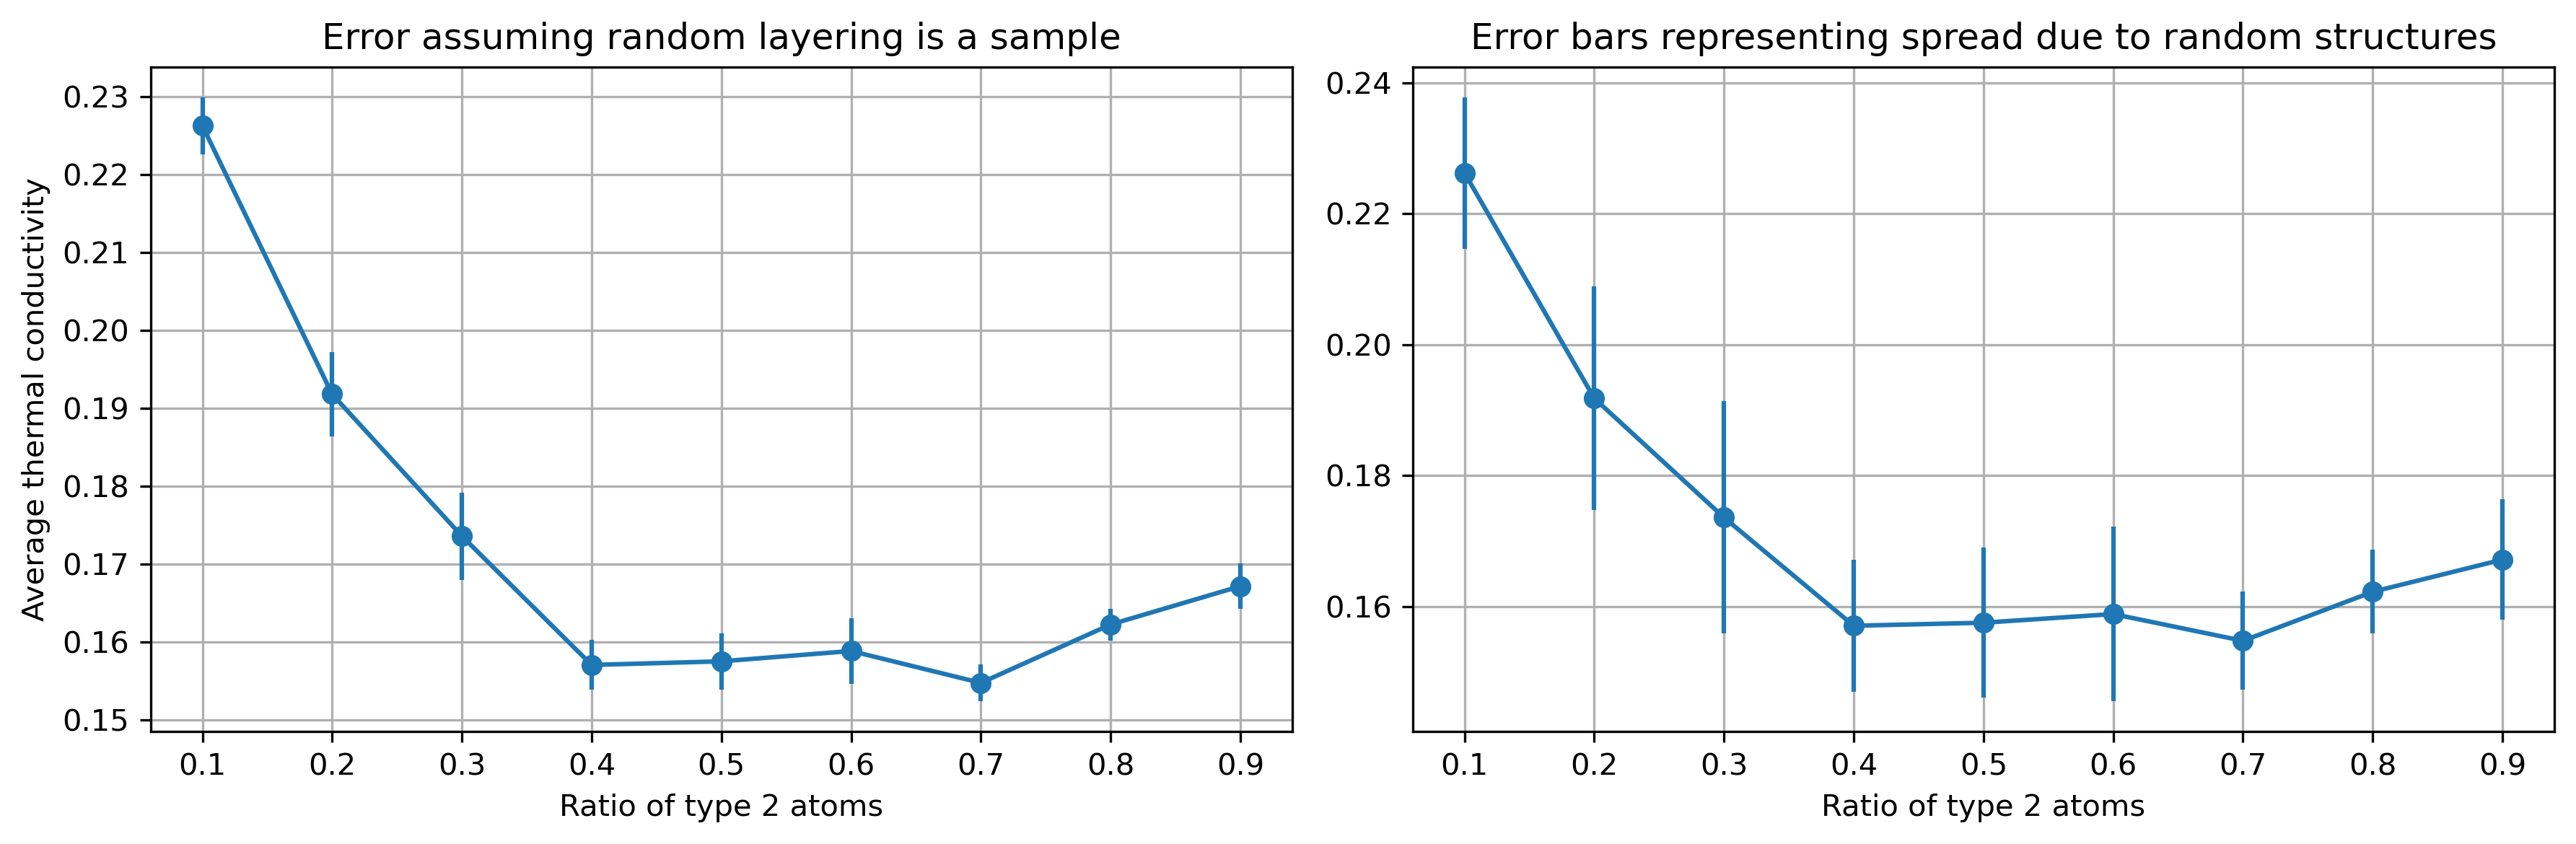

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left plot assumes the random structures are samples of each ratio
axes[0].errorbar(k_stats["ratio"], k_stats["k_mean"], yerr=k_stats["k_err"], fmt='-o')
axes[0].set_xlabel("Ratio of type 2 atoms"); axes[0].set_ylabel("Average thermal conductivity")
axes[0].set_title("Error assuming random layering is a sample")
axes[0].grid()

# Right plot plots error bars as just the spread due to the random structure
axes[1].errorbar(k_stats["ratio"], k_stats["k_mean"], yerr=k_stats["k_std"], fmt='-o')
axes[1].set_xlabel("Ratio of type 2 atoms")
axes[1].set_title("Error bars representing spread due to random structures")
axes[1].grid()

plt.tight_layout()

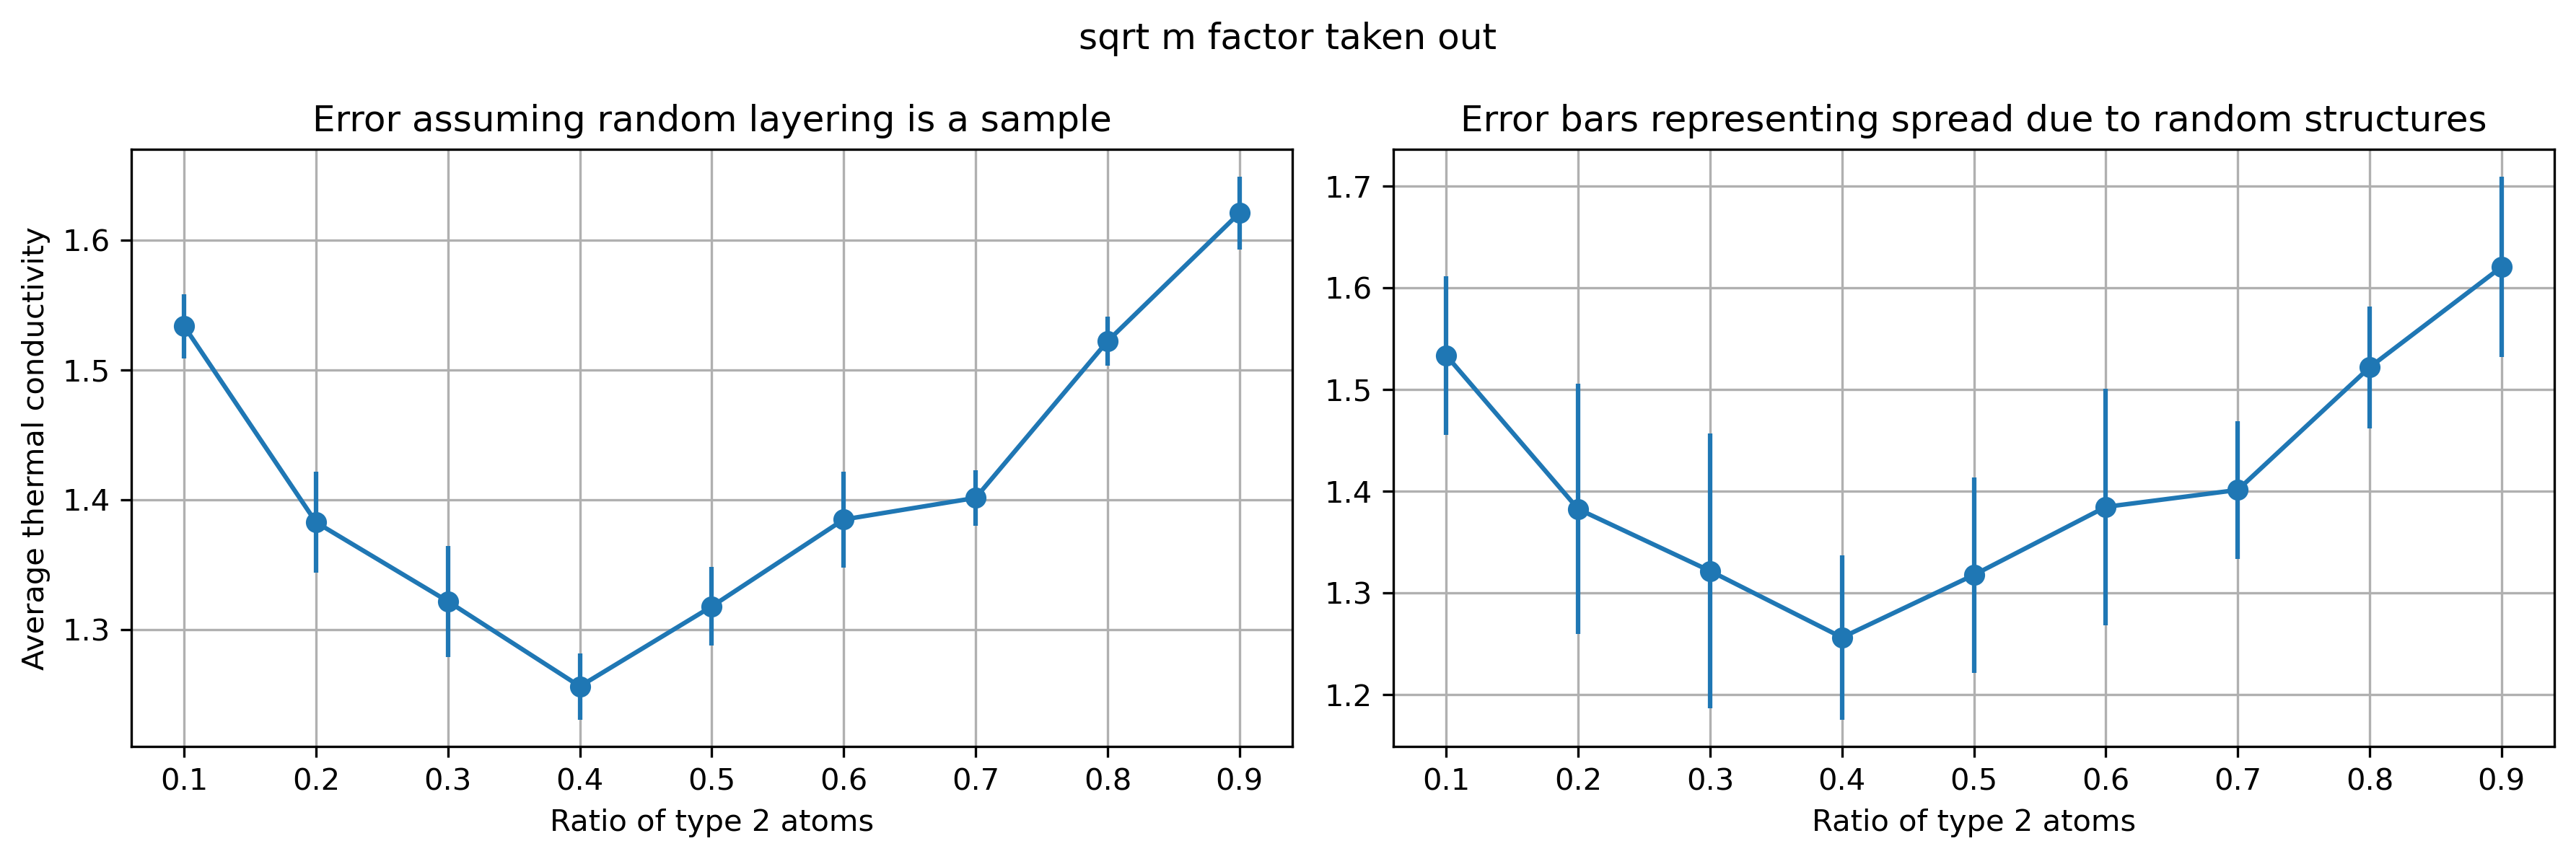

In [157]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left plot assumes the random structures are samples of each ratio
axes[0].errorbar(k_stats["ratio"], k_stats["k_mean"]*np.sqrt(avg_masses), yerr=k_stats["k_err"]*np.sqrt(avg_masses), fmt='-o')
axes[0].set_xlabel("Ratio of type 2 atoms"); axes[0].set_ylabel("Average thermal conductivity")
axes[0].set_title("Error assuming random layering is a sample")
axes[0].grid()

# Right plot plots error bars as just the spread due to the random structure
axes[1].errorbar(k_stats["ratio"], k_stats["k_mean"]*np.sqrt(avg_masses), yerr=k_stats["k_std"]*np.sqrt(avg_masses), fmt='-o')
axes[1].set_xlabel("Ratio of type 2 atoms")
axes[1].set_title("Error bars representing spread due to random structures")
axes[1].grid()

plt.suptitle("sqrt m factor taken out")
plt.tight_layout()

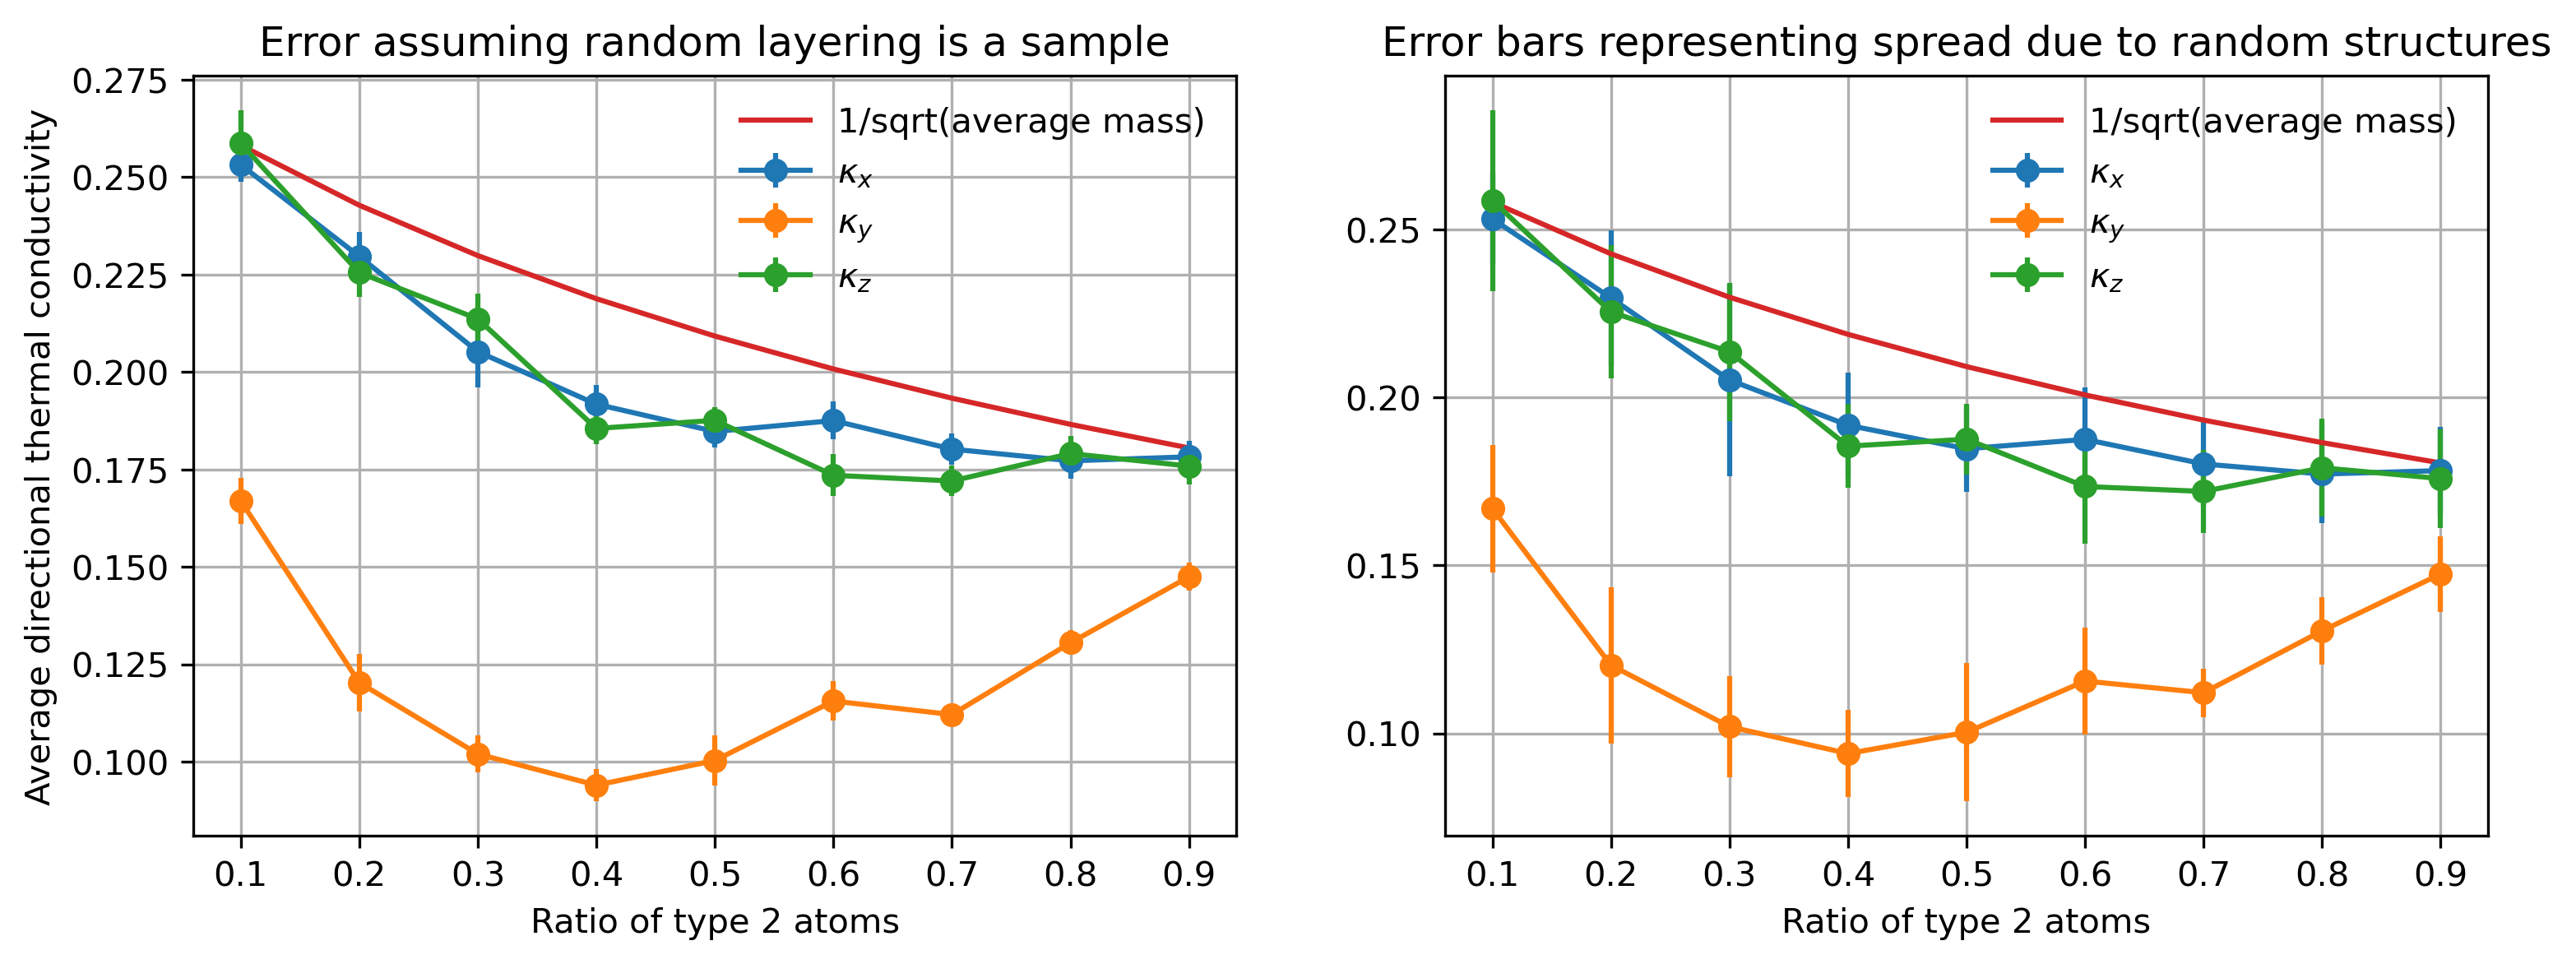

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].errorbar(k_stats["ratio"],k_stats["kx_mean"],yerr=k_stats["kx_err"], fmt='o-', label="$\kappa_x$")
axes[0].errorbar(k_stats["ratio"],k_stats["ky_mean"],yerr=k_stats["ky_err"], fmt='o-', label="$\kappa_y$")
axes[0].errorbar(k_stats["ratio"],k_stats["kz_mean"],yerr=k_stats["kz_err"], fmt='o-', label="$\kappa_z$")
axes[0].plot(ratios, 1.75/np.sqrt(avg_masses), label="1/sqrt(average mass)")
axes[0].set_xlabel("Ratio of type 2 atoms"); axes[0].set_ylabel("Average directional thermal conductivity")
axes[0].set_title("Error assuming random layering is a sample")
axes[0].grid(); axes[0].legend()

axes[1].errorbar(k_stats["ratio"],k_stats["kx_mean"],yerr=k_stats["kx_std"], fmt='o-', label="$\kappa_x$")
axes[1].errorbar(k_stats["ratio"],k_stats["ky_mean"],yerr=k_stats["ky_std"], fmt='o-', label="$\kappa_y$")
axes[1].errorbar(k_stats["ratio"],k_stats["kz_mean"],yerr=k_stats["kz_std"], fmt='o-', label="$\kappa_z$")
axes[1].plot(ratios, 1.75/np.sqrt(avg_masses), label="1/sqrt(average mass)")
axes[1].set_xlabel("Ratio of type 2 atoms")
axes[1].set_title("Error bars representing spread due to random structures")
axes[1].grid(); axes[1].legend()

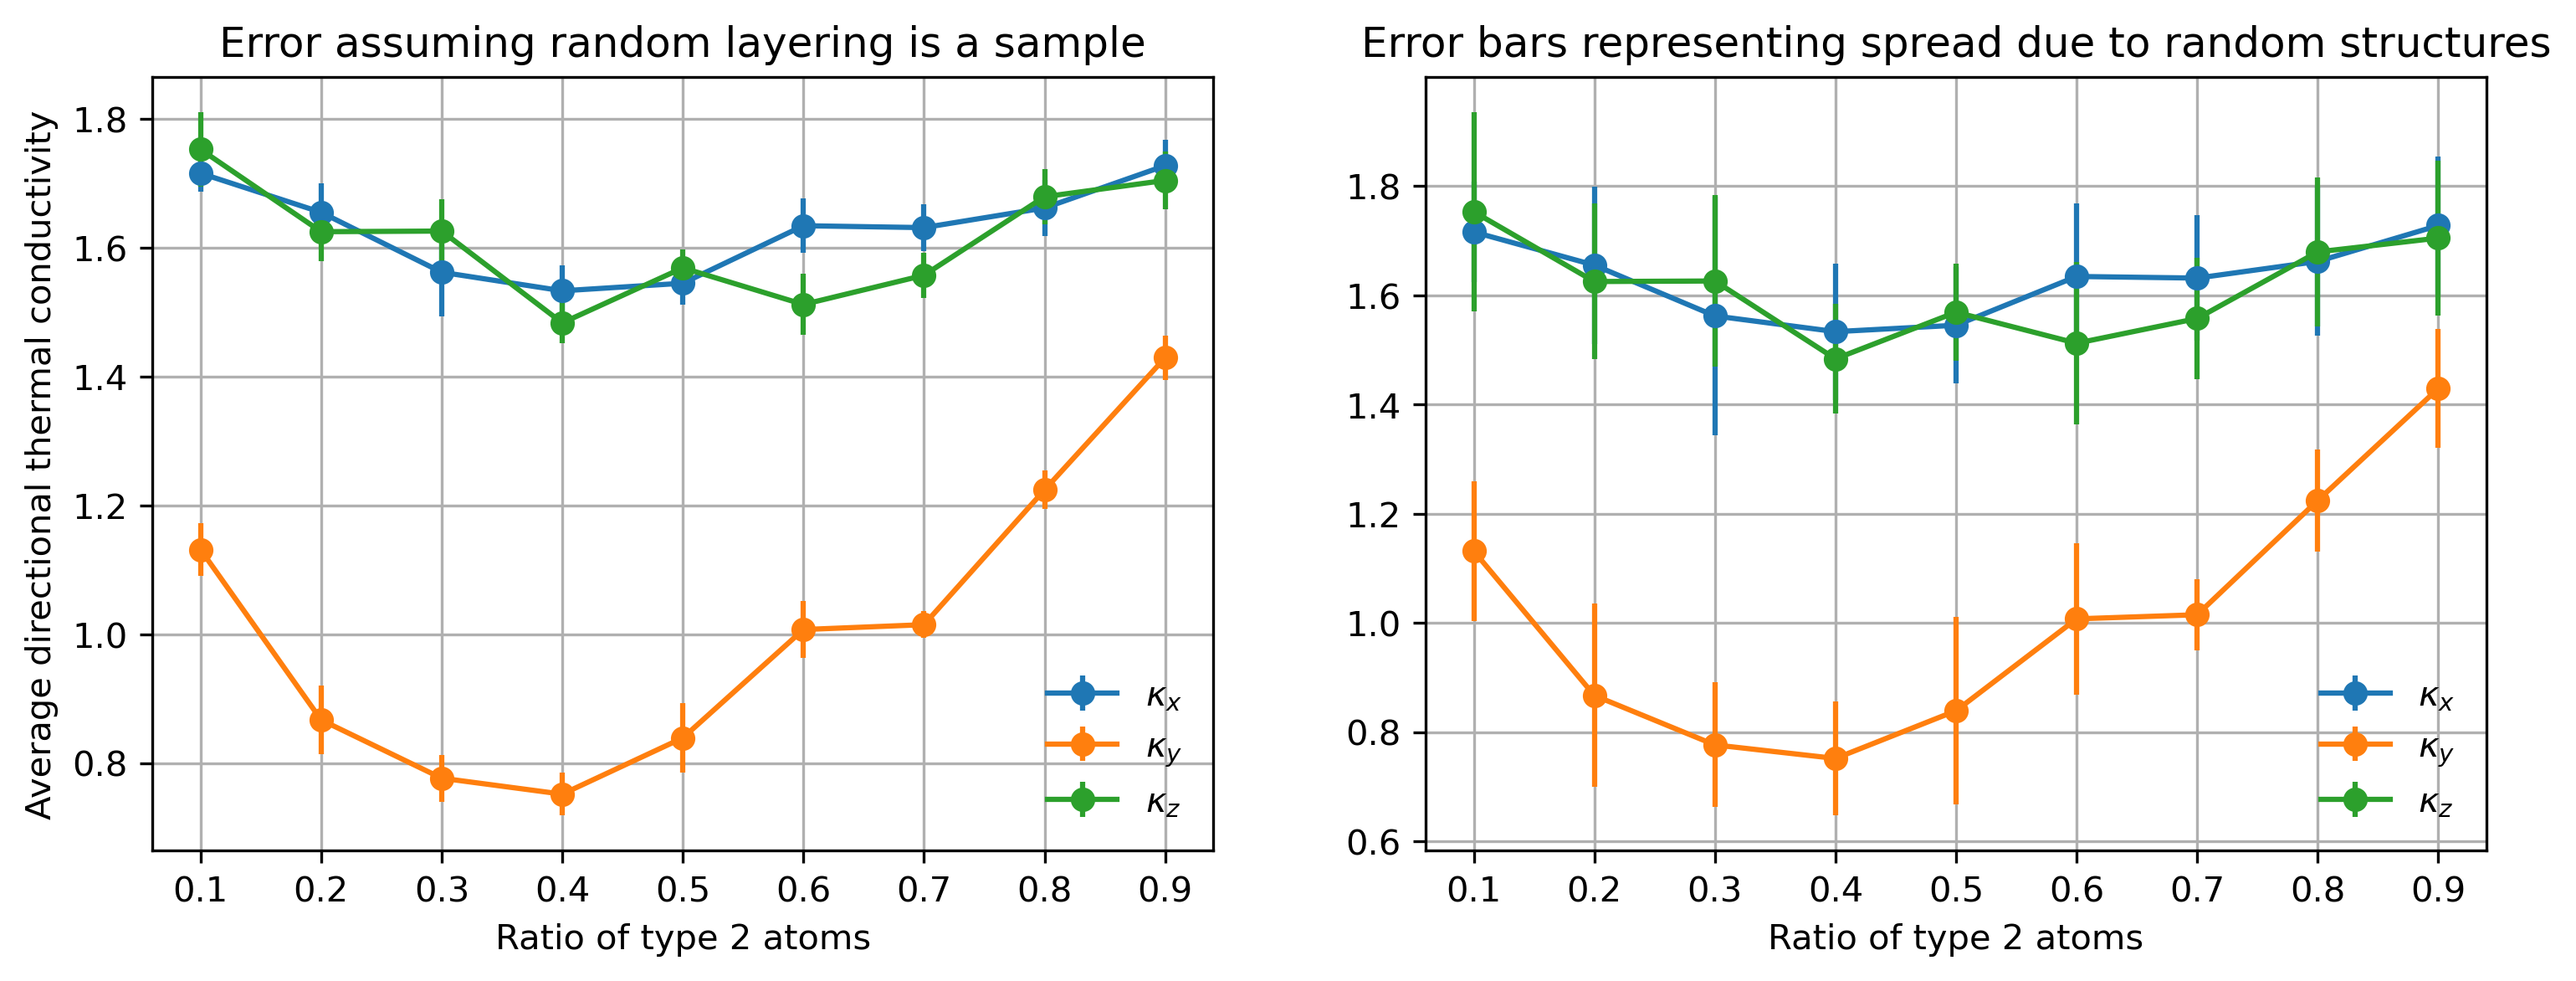

In [158]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].errorbar(k_stats["ratio"],k_stats["kx_mean"]*np.sqrt(avg_masses),yerr=k_stats["kx_err"]*np.sqrt(avg_masses), fmt='o-', label="$\kappa_x$")
axes[0].errorbar(k_stats["ratio"],k_stats["ky_mean"]*np.sqrt(avg_masses),yerr=k_stats["ky_err"]*np.sqrt(avg_masses), fmt='o-', label="$\kappa_y$")
axes[0].errorbar(k_stats["ratio"],k_stats["kz_mean"]*np.sqrt(avg_masses),yerr=k_stats["kz_err"]*np.sqrt(avg_masses), fmt='o-', label="$\kappa_z$")
#axes[0].plot(ratios, 1.75/np.sqrt(avg_masses), label="1/sqrt(average mass)")
axes[0].set_xlabel("Ratio of type 2 atoms"); axes[0].set_ylabel("Average directional thermal conductivity")
axes[0].set_title("Error assuming random layering is a sample")
axes[0].grid(); axes[0].legend()

axes[1].errorbar(k_stats["ratio"],k_stats["kx_mean"]*np.sqrt(avg_masses),yerr=k_stats["kx_std"]*np.sqrt(avg_masses), fmt='o-', label="$\kappa_x$")
axes[1].errorbar(k_stats["ratio"],k_stats["ky_mean"]*np.sqrt(avg_masses),yerr=k_stats["ky_std"]*np.sqrt(avg_masses), fmt='o-', label="$\kappa_y$")
axes[1].errorbar(k_stats["ratio"],k_stats["kz_mean"]*np.sqrt(avg_masses),yerr=k_stats["kz_std"]*np.sqrt(avg_masses), fmt='o-', label="$\kappa_z$")
#axes[1].plot(ratios, 1.75/np.sqrt(avg_masses), label="1/sqrt(average mass)")
axes[1].set_xlabel("Ratio of type 2 atoms")
axes[1].set_title("Error bars representing spread due to random structures")
axes[1].grid(); axes[1].legend()